# Extracting Scaffolds from a dataset of small molecules

In cheminformatics, analysing scaffolds from a dataset is important for several reasons: they represent the core structure of molecules, allowing chemists to organise and classify compounds into structural families. This aids in analyzing large chemical databases and libraries.

In addition, Scaffolds help in exploring how structural changes affect biological activity. By keeping the core scaffold constant and varying substituents, medicinal chemists can systematically study SAR.

Let's import all necessary libraries

In [1]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem.rdDepictor import Compute2DCoords
from io import StringIO
import mols2grid

and import Pat Walter's super-useful ```scaffold_finder.py```

In [2]:
import requests
#Import function from scaffold_finder.py placed in utils_pack directory
import sys
sys.path.append('/Users/ganesh.shahane/Work/useful_cheminformatics/utils_pack')
from utils_pack import scaffold_finder
from utils_pack.scaffold_finder import generate_fragments, find_scaffolds, get_molecules_with_scaffold, cleanup_fragment

# lib_file = requests.get("https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/sar_analysis/scaffold_finder.py")
# ofs = open("utils_pack/scaffold_finder.py","w")
# print(lib_file.text,file=ofs)
# ofs.close()

#from scaffold_finder import generate_fragments, find_scaffolds, get_molecules_with_scaffold, cleanup_fragment

### A Simple Example

As an example, let's consider four molecules with a common 5-HT core: LSD, Psilocybin, DMT, 5-Meo-DMT and psilocin:

In [3]:
molecules = """CN(C)CCc1c[nH]c2cccc(O)c12,mol_001
CN(C)CCc1c[nH]c2cccc(OP(=O)(O)O)c12,mol_002
CN(C)CCc1c[nH]c2ccccc12,mol_003
CN(C)CCC1=CNC2=C1C=C(C=C2)OC,mol_004
"""
fs = StringIO(molecules) # Simulating a file-like object for the example
df = pd.read_csv(fs, names=["SMILES","Name"])

df['mol'] = df.SMILES.apply(Chem.MolFromSmiles)

In [4]:
mols2grid.display(df, mol_col="mol",size=(200,200))

MolGridWidget()

Consider Psilocybin:

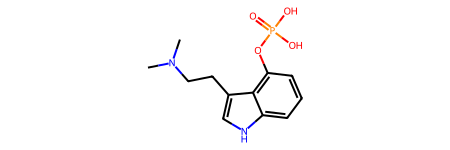

In [5]:
m1 = df.mol.values[1]
m1

Let's generate the fragments for it:

In [6]:
m1_frag_df = generate_fragments(m1)
m1_frag_df

,Scaffold,NumAtoms,NumRgroupgs
0,CNCCc1c[nH]c2cccc(OP(=O)(O)O)c12,18,1
1,NCCc1c[nH]c2cccc(OP(=O)(O)O)c12,17,2
2,CCc1c[nH]c2cccc(OP(=O)(O)O)c12,16,1
3,Cc1c[nH]c2cccc(OP(=O)(O)O)c12,15,1
4,O=P(O)(O)Oc1cccc2[nH]ccc12,14,1
5,NCCc1c[nH]c2ccccc12,12,3
9,CNCCc1c[nH]c2ccccc12,13,2
13,CCc1c[nH]c2ccccc12,11,2
17,CN(C)CCc1c[nH]c2ccccc12,14,1
18,CN(C)CCc1c[nH]c2cccc(OP(=O)(O)O)c12,19,1


In [7]:
mols2grid.display(m1_frag_df, smiles_col="Scaffold")

MolGridWidget()

We can do the same thing with Psilocin:

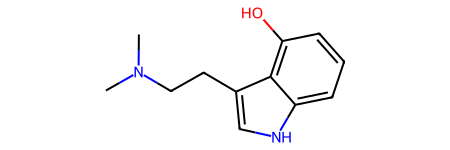

In [8]:
m0 = df.mol.values[0]
m0

In [9]:
m0_frag_df = generate_fragments(m0)
m0_frag_df

,Scaffold,NumAtoms,NumRgroupgs
0,CNCCc1c[nH]c2cccc(O)c12,14,1
1,NCCc1c[nH]c2cccc(O)c12,13,2
2,CCc1c[nH]c2cccc(O)c12,12,1
3,Cc1c[nH]c2cccc(O)c12,11,1
4,Oc1cccc2[nH]ccc12,10,1
5,NCCc1c[nH]c2ccccc12,12,3
9,CNCCc1c[nH]c2ccccc12,13,2
13,CCc1c[nH]c2ccccc12,11,2
16,Cc1c[nH]c2ccccc12,10,2
18,c1ccc2[nH]ccc2c1,9,2


In [10]:
mols2grid.display(m0_frag_df,smiles_col="Scaffold")

MolGridWidget()

Let's combine the fragments from m0 and m1 to one dataframe

In [11]:
m0m1_frag_df = pd.concat([m1_frag_df,m0_frag_df])

We can then use Pandas **groupby** to record the frequency of occurrence of each fragment.

In [12]:
scaffold_list = []

for k,v in m0m1_frag_df.groupby("Scaffold"):
    scaffold_list.append([k,len(v),v.NumAtoms.values[0]])

scaffold_df = pd.DataFrame(scaffold_list,columns=["Scaffold","Count","NumAtoms"])

In [13]:
scaffold_df.sort_values(["Count","NumAtoms"],ascending=[False,False],inplace=True)

In [14]:
scaffold_df.head(3)

,Scaffold,Count,NumAtoms
5,CN(C)CCc1c[nH]c2ccccc12,2,14
8,CNCCc1c[nH]c2ccccc12,2,13
14,NCCc1c[nH]c2ccccc12,2,12


The table below records the frequency of occurrence of each fragment.

In [15]:
mols2grid.display(scaffold_df, smiles_col="Scaffold", subset=["img","Count","NumAtoms"])

MolGridWidget()

We can use the function **find_scaffolds** to find scaffolds in the set of five molecules above.

In [16]:
mol_df, scaf_df = find_scaffolds(df)

mols2grid.display(scaf_df, smiles_col="Scaffold", subset=["img","Count","NumAtoms"])

  0%|          | 0/4 [00:00<?, ?it/s]

MolGridWidget()

## A more substantial example

Identifying scaffolds in a set of five molecules is a somewhat trivial problem. Let's take a look at a larger set of molecules from the ChEMBL database. We'll start by reading the input data.

In [ ]:
infile_url = "https://raw.githubusercontent.com/PatWalters/practical_cheminformatics_tutorials/main/data/CHEMBL208.smi"
chembl208_df = pd.read_csv(infile_url,names=["SMILES","Name","pIC50"])

print(f"The dataset has {chembl208_df.shape[0]} molecules")
chembl208_df.head()

The dataset has 513 molecules


,SMILES,Name,pIC50
0,O=c1[nH]c2ccc(-c3cccc(Cl)c3)cc2s1,CHEMBL94053,6.90
1,O=c1[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)cc2n1Cc1...,CHEMBL327409,6.15
2,CC1=CC(C)(C)Nc2ccc(-c3cccc([N+](=O)[O-])c3)cc21,CHEMBL93027,7.70
3,CC(C)n1c(=O)[nH]c2ccc(-c3cccc(Cl)c3)cc21,CHEMBL329631,6.28
4,CC(C)n1c(=O)[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)...,CHEMBL327444,6.28


First we'll add a column with RDKit molecules to the dataframe.

In [ ]:
chembl208_df['mol'] = chembl208_df.SMILES.apply(Chem.MolFromSmiles)

Check how the molecules look like:

In [ ]:
mols2grid.display(chembl208_df.mol, mol_col="mol",size=(100,100))

MolGridWidget()

Next, we can identify scaffolds.

In [ ]:
mol_df, scaffold_df = find_scaffolds(chembl208_df)

  0%|          | 0/513 [00:00<?, ?it/s]

In [ ]:
mol_df.head()

,Scaffold,NumAtoms,NumRgroupgs,Name,SMILES
0,O=c1[nH]c2ccc(-c3ccccc3)cc2s1,16,1,CHEMBL94053,O=c1[nH]c2ccc(-c3cccc(Cl)c3)cc2s1
1,O=c1[nH]c2ccc(-c3cccc(Cl)c3)cc2s1,17,1,CHEMBL94053,O=c1[nH]c2ccc(-c3cccc(Cl)c3)cc2s1
0,O=c1[nH]c2ccccc2n1Cc1ccccc1,17,1,CHEMBL327409,O=c1[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)cc2n1Cc1...
2,O=c1[nH]c2ccc(-c3ccccc3)cc2n1Cc1ccccc1,23,1,CHEMBL327409,O=c1[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)cc2n1Cc1...
3,O=c1[nH]c2ccc(-c3ccccc3)cc2[nH]1,16,2,CHEMBL327409,O=c1[nH]c2ccc(-c3cccc([N+](=O)[O-])c3)cc2n1Cc1...


Let's take a look at the scaffolds

In [ ]:
scaffold_df

,Scaffold,Count,NumAtoms
5012,CC1=CC(C)(C)Nc2ccc3c(c21)COc1ccccc1-3,108,21
4312,CC1(C)C=Cc2c(ccc3c2COc2ccccc2-3)N1,93,20
5396,CC1=CC(C)Nc2ccc3c(c21)COc1ccccc1-3,92,20
2555,C=C1Oc2ccccc2-c2ccc3c(c21)C(C)=CC(C)(C)N3,64,22
2556,C=C1Oc2ccccc2-c2ccc3c(c21)C(C)=CC(C)N3,50,21
...,...,...,...
3933,CC(C)n1c(=O)[nH]c2ccccc21,1,13
11729,O=[SH](=O)Nc1ccc2cc[nH]c2c1,1,13
7372,CCn1c(=O)[nH]c2ccccc21,1,12
11001,Cn1c(=O)[nH]c2ccccc21,1,11


In [ ]:
mols2grid.display(scaffold_df.head(10),smiles_col="Scaffold", subset=["img","Count"])

MolGridWidget()

The scaffolds above are sorted by frequency. We can look at the molecules containing the most frequently occurring scaffold by selecting the first scaffold in scaffold_df.

In [ ]:
scaffold_0 = scaffold_df.Scaffold.values[0]

The function **get_molecules_with_scaffold** will return all the molecules containing the specified scaffold. This function returns two values.

- A list of scaffolds with R-group substitution points labeled
- A dataframe with molecules containing that scaffold

In [ ]:
scaffold_smiles_list, chembl208_mol_df = get_molecules_with_scaffold(scaffold_0, mol_df, chembl208_df)

Let's look at the scaffold with R-group labels.

In [ ]:
scaffold_smiles_list
chembl208_mol_df

,SMILES,Name,pIC50
0,C/C=C\C1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3,CHEMBL138197,6.14
1,CCOC(=O)C1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)...,CHEMBL138003,6.02
2,CCCCC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3,CHEMBL140336,5.77
3,COc1cccc2c1-c1ccc3c(c1C(C)O2)C(C)=CC(C)(C)N3,CHEMBL141836,5.37
4,C#CCC1Oc2cccc(OC)c2-c2ccc3c(c21)C(C)=CC(C)(C)N3,CHEMBL138098,6.12
...,...,...,...
103,COc1ccc2c(c1)-c1ccc3c(c1C(c1ccccc1)O2)C(C)=CC(...,CHEMBL317983,6.41
104,COc1cccc2c1-c1ccc3c(c1C(c1cccc(C(F)(F)F)c1)O2)...,CHEMBL95644,5.40
105,CC1=CC(C)(C)Nc2ccc3c(c21)[C@H]([C@@H]1C=CCCC1)...,CHEMBL510305,8.32
106,CC1=CC(C)(C)Nc2ccc3c(c21)[C@H]([C@H]1CCC[C@@]2...,CHEMBL507701,8.92


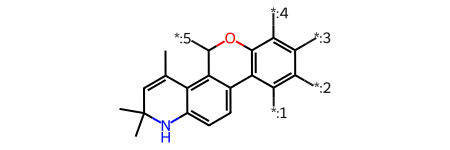

In [ ]:
scaffold_mol = Chem.MolFromSmiles(scaffold_smiles_list[0])
scaffold_mol

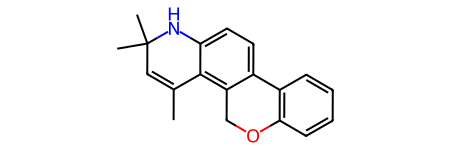

In [ ]:
clean_scaffold_mol, _ = cleanup_fragment(scaffold_mol)
Compute2DCoords(clean_scaffold_mol)
clean_scaffold_mol

With this scaffold in hand, we can generate aligned structures for the molecules.

In [ ]:
chembl208_mol_df['mol'] = chembl208_mol_df.SMILES.apply(Chem.MolFromSmiles)

In [ ]:
for mol in chembl208_mol_df.mol:
    AllChem.GenerateDepictionMatching2DStructure(mol,clean_scaffold_mol)

In [ ]:
mols2grid.display(chembl208_mol_df.sort_values("pIC50",ascending=False),
                  mol_col='mol',use_coords=True, prerender=True, substruct_highlight=False,
                  transform={"pIC50" : lambda x: f"{x:.1f}"},
                  subset=["img","Name","pIC50"])

MolGridWidget()